In [107]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp
from jax.example_libraries.stax import Tanh
import pandas as pd
import optax

In [108]:
from model.nn import RealNVP, make_transform
from model.loss import make_error_loss

In [ ]:
dim = 2
nlayers = 3
hidden = 6
activation = Tanh

transform = make_transform(hidden, activation)
flow_init = RealNVP(transform, nlayers)

rng = jax.random.PRNGKey(42)
init_rng, rng = jax.random.split(rng)
params, flow_forward, flow_inverse = flow_init(init_rng, dim)

basis = lambda tau: jnp.array([1.0, tau[0]**4 + tau[1]**2, tau[0]**2)
_, train_loss, coefficients = make_error_loss(flow_forward, basis, "./ammonia/nh3_inv_pes_train.txt")
valid_loss, _, _ = make_error_loss(flow_forward, basis, "./ammonia/nh3_inv_pes_valid.txt")
test_loss, _, _ = make_error_loss(flow_forward, basis, "./ammonia/nh3_inv_pes_test.txt")
value_and_grad = jax.value_and_grad(train_loss, argnums=0, has_aux=False)

step_size = 5e-4

params_optimizer = optax.adam(step_size)
params_opt_state = params_optimizer.init(params)

In [110]:
@jax.jit
def step(params, params_opt_state):
    value, grad = value_and_grad(params)
    params_updates, params_opt_state = params_optimizer.update(grad, params_opt_state)
    params = optax.apply_updates(params, params_updates)
    return value, params, params_opt_state

In [111]:
train_loss_history = []
valid_loss_history = []
# test_loss_history = []
nsteps = 3000
for i in range(nsteps):
    value, params, params_opt_state = step(params, params_opt_state)
    u = coefficients(params)
    train_loss_history.append(value)
    valid_loss_history.append(valid_loss(params, u))
    # test_loss_history.append(test_loss(params, u0))
    print(i, value)
# print(u0)
print(test_loss(params, u))
print(u)
output = flow_inverse(params, jnp.array([[0, 0]]))

0 0.08068984788486688
1 0.0804031233114254
2 0.08011229815309384
3 0.07981712804847213
4 0.07951739950543124
5 0.07921289119389063
6 0.07890336905211581
7 0.07858858433539706
8 0.07826827281051107
9 0.0779421547996364
10 0.07760993455382059
11 0.07727129825968193
12 0.07692591143297589
13 0.07657341650199034
14 0.07621343109386153
15 0.07584554731652943
16 0.07546933190355615
17 0.07508432652732966
18 0.07469004732505152
19 0.07428598300606803
20 0.07387159146350841
21 0.07344629511150635
22 0.07300947540467773
23 0.07256046780058184
24 0.07209855933578835
25 0.07162298946111445
26 0.07113295106063561
27 0.070627588497299
28 0.07010599310564164
29 0.06956719802650146
30 0.06901017341335319
31 0.06843382232002104
32 0.06783697757769935
33 0.0672184002492694
34 0.06657678027771796
35 0.065910739397535
36 0.0652188357004303
37 0.06449956930143286
38 0.06375138930040447
39 0.06297270292834478
40 0.062161888163708434
41 0.06131731145569835
42 0.060437352652038756
43 0.05952043977361643
44 0

/var/folders/hf/60jhbx_s40b92cvfxl5gbbb80000gn/T/ipykernel_988/2068783962.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


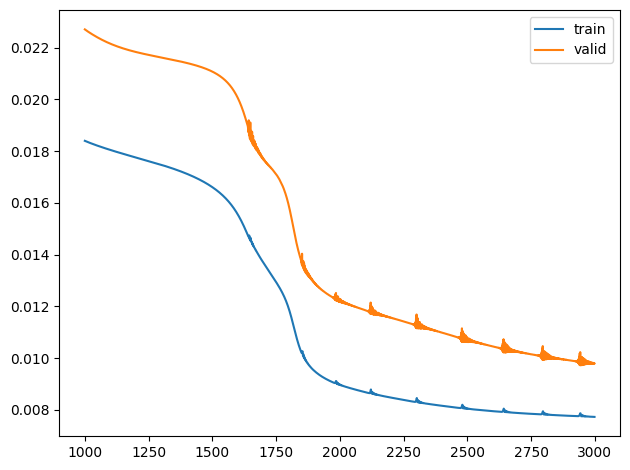

In [112]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
start_step = 1000
ax.plot(range(start_step, nsteps), train_loss_history[start_step:nsteps], label = "train")
ax.plot(range(start_step, nsteps), valid_loss_history[start_step:nsteps], label = "valid")
# ax.plot(range(start_step, nsteps), test_loss_history[start_step:nsteps], label = "test")
ax.legend(loc="upper right")
fig.tight_layout()
fig.show()

In [113]:
print(output[0][0])
print(output[0][1])

0.6670257535804837
-1.7785061642381432


In [114]:
from ammonia.pes import ammonia_pes
r_exact = 1.0102908
t_exact = jnp.pi / 2
a_exact = 2 * jnp.asin(jnp.sqrt(3) * jnp.sin(t_exact) / 2)
theta = jnp.arange(jnp.pi/3, 2*jnp.pi/3, 0.01)
bond = jnp.arange(0.8, 1.2, 0.005)
alpha = 2 * jnp.asin(jnp.sqrt(3) * jnp.sin(theta) / 2)
angle_vary = jnp.array([[r_exact, r_exact, r_exact, a, a, a] for a in alpha])
bond_vary = jnp.array([[r, r, r, t_exact, t_exact, t_exact] for r in bond])
batched_pes = jax.vmap(ammonia_pes)
pes_angle_exact = batched_pes(angle_vary) / 1e4
pes_bond_exact = batched_pes(bond_vary) / 1e4

In [115]:
angle_input = jnp.array([[t, r_exact] for t in theta])
bond_input = jnp.array([[t_exact, r] for r in bond])
angle_tau = flow_forward(params, angle_input)
bond_tau = flow_forward(params, bond_input)
transformed_pes = lambda tau: jnp.dot(u, basis(tau))
batched_pot = jax.vmap(transformed_pes)
pes_angle_reg = batched_pot(angle_tau)
pes_bond_reg = batched_pot(bond_tau)

/var/folders/hf/60jhbx_s40b92cvfxl5gbbb80000gn/T/ipykernel_988/3375021634.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_.show()


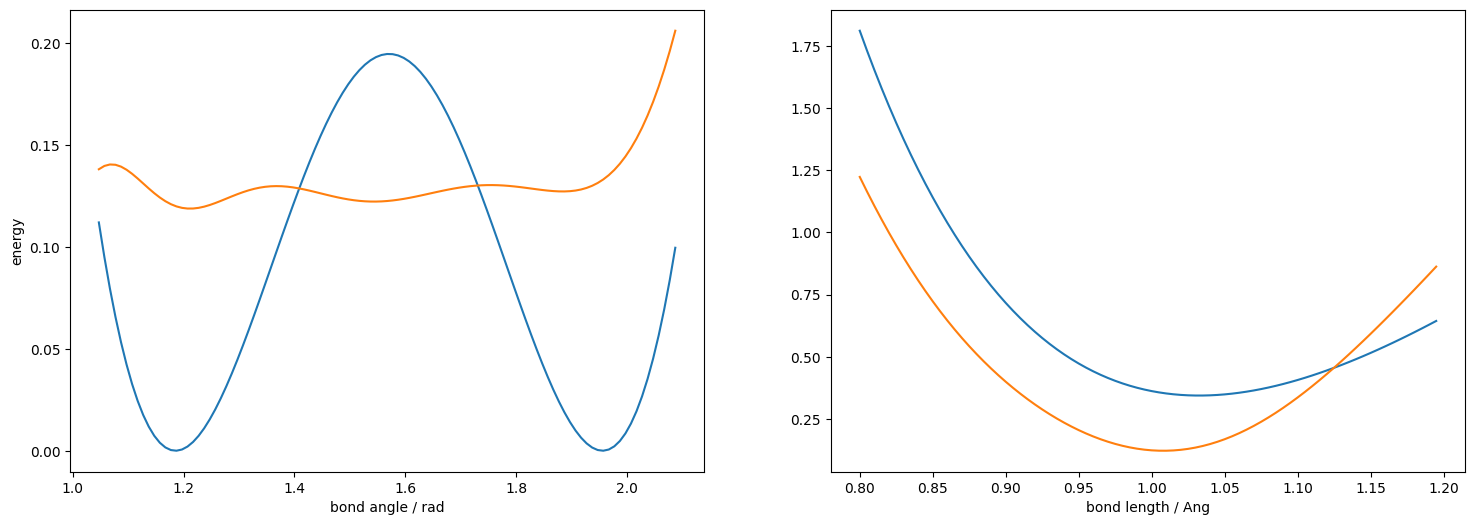

In [116]:
fig_ = plt.figure(figsize=(18, 6))
ax_ = fig_.subplots(1, 2)
ax_[0].plot(theta, pes_angle_exact)
ax_[0].plot(theta, pes_angle_reg)
ax_[0].set_xlabel("bond angle / rad")
ax_[0].set_ylabel("energy")
ax_[1].plot(bond, pes_bond_exact)
ax_[1].plot(bond, pes_bond_reg)
ax_[1].set_xlabel("bond length / Ang")
fig_.show()